In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import ast
import nltk
import copy
import tqdm
import os
import gensim
import re

from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag #Penn Treebank tag set
from nltk.corpus import wordnet as wn 
from nltk.corpus import stopwords
from nltk.corpus import words
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
tensorflow.config.experimental.set_memory_growth(tensorflow.config.experimental.list_physical_devices('GPU')[0], True)

In [3]:
df = pd.read_csv(r'C:\Users\Tudor\Desktop\SentimentAnalysis\train.csv')
original = copy.deepcopy(df)
df.head(5)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [4]:
# A little bit imbalanced
print("Offense texts:", df['is_humor'][df['is_humor'] == 0].count())
print("Humor texts:", df['is_humor'][df['is_humor'] == 1].count())
print("Total texts:", len(df))

Offense texts: 3068
Humor texts: 4932
Total texts: 8000


In [5]:
balanced = True
if balanced == False:
    data_frames = [df[df['is_humor'] == 1].sample(3068), df[df['is_humor'] == 0]]
    new_df = pd.concat(data_frames, sort=False)
    new_df.reset_index(drop=True, inplace=True)
    print("Offense texts:", new_df['is_humor'][new_df['is_humor'] == 0].count())
    print("Humor texts:", new_df['is_humor'][new_df['is_humor'] == 1].count())
    print("Total texts:", len(new_df))
    df = copy.deepcopy(new_df)

In [ ]:
%%time

# Lower all texts
df['text'] = df['text'].apply(lambda elem : elem.lower())

# Tokenize the texts into words
df['text'] = df['text'].apply(lambda elem : nltk.tokenize.word_tokenize(elem))

# [state-of-the-art] [#, rezist]


def my_func(elem):
    global new_l
    if re.search("\*", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("\*", elem))))
    elif re.search("=", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("=", elem))))
    elif re.search("~", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("~", elem))))
    elif re.search("#", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("#", elem))))
    elif re.search("\$", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("\$", elem))))
    elif re.search("@", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("@", elem))))
    elif re.search("\"", elem):
        new_l.extend(list(filter(lambda e : e != '', re.split("\"", elem))))
    elif re.search("\-", elem):
        sir = ""
        for _ in list(filter(lambda e : e != '', re.split("-", elem))):
            sir += _
        if sir in words.words():
            new_l.append(sir)
        else:
            new_l.extend(list(filter(lambda e : e != '', re.split("-", elem))))
    else:
        new_l.append(elem)

l = []
for i in range(0, len(df['text'])):
    if re.search("[\*#~=\$@\-]", ''.join(df.loc[i]['text'])):
        new_l = []
        for elem in df.loc[i]['text']:    
            my_func(elem)
        aux_new_l = df.loc[i]['text']
        while new_l != aux_new_l:
            aux_new_l = copy.deepcopy(new_l)
            new_l = []
            for elem in aux_new_l:
                my_func(elem)
        l.append(new_l)
    else:
        l.append(df.loc[i]['text'])
df['text'] = l


# Remove non alphanumeric words 
df['text'] = df['text'].apply(lambda elem : [word for word in elem if word.isalnum()])

# https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word
# The above link explains the following
# Keep only the canonical forms of the words 
tag_to_pos = lambda elem : elem.lower() if elem in ['N', 'V', 'R'] else 'a'
df['text'] = df['text'].apply(lambda elem : [nltk.stem.WordNetLemmatizer().lemmatize(word=word_pos[0], pos=tag_to_pos(word_pos[1][0]))
                                             if word_pos[1][0] in ('N', 'V', 'R', 'J') #if NOUN, VERB, ADVERB, ADJ
                                             else word_pos[0] 
                                             for word_pos in nltk.pos_tag(elem)])

# Get rid of stopwords (eg: the, is, at etc)
stopWords = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda elem : [word for word in elem if word not in stopWords])

# Make a set of all the unique words in the dataframe (might be useful later)
set_of_words = set()
aux = []
for elem in df['text']:
    set_of_words.update(elem)
    aux.extend(elem)

# Make a dictionary of words so that you know how many times each word appears in the dataframe (might be useful later)
d_of_words = dict(zip(set_of_words, [0 for _ in range(0, len(set_of_words))]))
for key in d_of_words.keys():
    d_of_words[key] = aux.count(key)
del aux

set_of_words = list(set_of_words)
print("Number of unique words:", len(set_of_words))

In [7]:
%%time

# Document-Term matrix
# mydataframe = mydataframe.append(new_row, ignore_index=True)
if os.path.exists(r'C:\Users\Tudor\Desktop\SentimentAnalysis\doc_term.csv'):
    doc_term = pd.read_csv(r'C:\Users\Tudor\Desktop\SentimentAnalysis\doc_term.csv')
    doc_term.drop('Unnamed: 0', axis=1, inplace=True)
else:
    doc_term = pd.DataFrame(columns = set_of_words)
    for elem in df['text']:
        row = [0 for _ in range(0, len(set_of_words))]
        for word in elem:
            row[set_of_words.index(word)] += 1
        doc_term = doc_term.append(dict(zip(set_of_words, row)), ignore_index=True)

    doc_term['is_humor'] = df['is_humor']
    doc_term['humor_rating'] = df['humor_rating']
    doc_term['humor_controversy'] = df['humor_controversy']
    doc_term['offense_rating'] = df['offense_rating']
    doc_term.to_csv(r'C:\Users\Tudor\Desktop\SentimentAnalysis\doc_term.csv')
    doc_term = pd.read_csv(r'C:\Users\Tudor\Desktop\SentimentAnalysis\doc_term.csv')
    doc_term.drop('Unnamed: 0', axis=1, inplace=True)

    
# One hot encoding
one_hot = copy.deepcopy(doc_term)
one_hot[one_hot.columns[:-4]] = one_hot[one_hot.columns[:-4]].apply(lambda line : list(map(lambda elem : 1 if elem >= 1 else 0, line)), axis=0)


# tf-idf encoding 
tf_idf = pd.DataFrame(TfidfTransformer(smooth_idf=False, norm=None).fit_transform(doc_term[doc_term.columns[:-4]].values).toarray(),
                           columns=doc_term.columns[:-4])
for column in doc_term.columns[-4:]:
    tf_idf[column] = list(doc_term[column])

Wall time: 2min 7s


In [8]:
doc_term_train, doc_term_test = train_test_split(doc_term, train_size=0.75, test_size=0.25, shuffle=True)

one_hot_train = one_hot.loc[doc_term_train.index.tolist()]
one_hot_test = one_hot.loc[doc_term_test.index.tolist()]

tf_idf_train = tf_idf.loc[doc_term_train.index.tolist()]
tf_idf_test = tf_idf.loc[doc_term_test.index.tolist()]

print("Training set length:", len(doc_term_train))
print("Testing set length:", len(doc_term_test))

Training set length: 6000
Testing set length: 2000


In [9]:
df_nn = copy.deepcopy(df)
tokenizer = Tokenizer()
'''
fit_on_texts function -> Updates internal vocabulary based on a list of texts.
# In the case where texts contain lists, we assume each entry of the lists to be a token.

source -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts
'''
tokenizer.fit_on_texts(df_nn['text'])
df_nn['text'] = tokenizer.texts_to_sequences(df_nn['text']) # assign unique integers (starting from 1) to words


'''
 1) Construct word2vec matrix; words are on lines and on columns I got the values of the word2vec vector for each word
 2) Do the required padding of the texts in order to have same length sequences 
'''
word_dimension = 5
word2vec = gensim.models.Word2Vec(sentences=df['text'], size=word_dimension, min_count=1, workers=4)
word2vec_matrix = np.zeros((len(set_of_words) + 1, word_dimension)) # + 1 because I also got an embedding for 0, the padded val
for key, value in tokenizer.word_index.items():
    word2vec_matrix[value] = word2vec.wv[key]
pads = pad_sequences(df_nn['text'], maxlen=max([len(elem) for elem in df['text']]), padding='post', value=0.0) # pad the sequenes such that all sequences are of length equal to the longest sequence length 
df_nn['text'] = pads.tolist()
print(word2vec_matrix)
print()
print(df_nn['text'])


# '''
#  Properly construct the training, testing sets for the Vanilla RNN 
# ''' 

# int_word_dict = dict([(value, key) for key, value in tokenizer.word_index.items()])

# train_df_nn, test_df_nn = train_test_split(df_nn, train_size=0.80, test_size=0.20, shuffle=True)

# X_train = []
# for sentence in train_df_nn['text']:
#     x = []
#     x.insert(0, None)
#     for elem in sentence:
#         vec = np.zeros((len(set_of_words) + 1, 1))
#         if elem != 0:
#             vec[set_of_words.index(int_word_dict[elem])] = 1
#         x.append(vec)
#     X_train.append(x)

# Y_train = []
# for label in train_df_nn['is_humor']:    
#     Y_train.append(np.array([label, 1 - label]).reshape((2, 1)))

# X_test = []
# for sentence in test_df_nn['text']:
#     x = []
#     x.insert(0, None)
#     for elem in sentence:
#         vec = np.zeros((len(set_of_words) + 1, 1))
#         if elem != 0:
#             vec[set_of_words.index(int_word_dict[elem])] = 1
#         x.append(vec)
#     X_test.append(x)

# Y_test = []
# for label in test_df_nn['is_humor']:    
#     Y_test.append(np.array([label, 1 - label]).reshape((2, 1)))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.16670322e+00 -3.59312010e+00  6.56951189e-01 -8.46710384e-01
   5.23286057e+00]
 [-3.08679557e+00 -3.53564262e+00  7.89312780e-01 -8.79459560e-01
   5.17685032e+00]
 ...
 [-1.20738111e-01  9.21519753e-03 -1.31335575e-02  1.81944892e-02
   2.40752678e-02]
 [-9.16644782e-02 -1.05623074e-01  8.75356495e-02  6.80792779e-02
   5.99072687e-02]
 [-2.83900392e-03  1.86039240e-03  1.22785874e-04 -3.35842483e-02
  -1.32259000e-02]]

0       [2087, 70, 228, 536, 76, 33, 290, 6004, 71, 23...
1       [27, 6005, 4252, 6006, 9, 13, 143, 14, 609, 17...
2       [83, 101, 18, 152, 446, 559, 152, 12, 215, 143...
3       [6007, 216, 262, 4253, 300, 1553, 274, 476, 96...
4       [2825, 391, 15, 686, 994, 2826, 841, 1207, 0, ...
                              ...                        
7995    [814, 802, 11446, 982, 886, 11447, 40, 18, 114...
7996    [11449, 97, 39, 221, 0, 0, 0, 0, 0, 0, 0, 0, 0...
7997    [56, 5881, 

In [10]:
class RNN_M2O:
    #word_dim may be 'one-hot', 'bag-of-words', word_dimension(int value) 
    def __init__(self, nr_hls, neurons_per_layer, learning_rate, epochs, vocab, X, Y, word_dim):
        self.nr_hls = nr_hls; self.neurons_per_layer = neurons_per_layer; self.etha = learning_rate; self.epochs = epochs;
        self.vocab = vocab; self.X = X; self.Y = Y; self.word_dim = word_dim
        
        # verifies what we're using aka one hot, bag of words or word2vec encoding 
        aux_func = lambda check : self.word_dim if type(check) is int else len(self.vocab)
        
        self.s = [np.zeros((self.neurons_per_layer, 1)) for _ in range(0, self.nr_hls + 1)]
        self.o = None
        
        self.W = np.random.normal(0, np.sqrt(1 / (self.neurons_per_layer - 1)), (self.neurons_per_layer, self.neurons_per_layer))
        self.U = np.random.normal(0, np.sqrt(1 / (aux_func(self.word_dim) - 1)), (self.neurons_per_layer, aux_func(self.word_dim)))
        self.V = np.random.normal(0, np.sqrt(1 / (self.neurons_per_layer - 1)), (2, self.neurons_per_layer))
        
    def relu(self, z):
        return np.array([np.array(list(map(lambda e : max(0, e), line))) for line in z])
    
    def relu_deriv(self, z):
        return  np.array([np.array(list(map(lambda e : 1 if e >=0 else 0.01 * e, line))) for line in z])
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0)
    
    def forward_propagation(self, X):
        for i in range(1, len(X)):
            z = np.dot(self.W, self.s[i - 1]) + np.dot(self.U, X[i])
            self.s[i] = self.relu(z)
        z = np.dot(self.V, self.s[i])
        self.o = self.softmax(z)
    
    def back_propagation(self, X, Y):
        error = self.o - Y
        self.V -= self.etha * np.dot(error, self.s[-1].T)
        
        gradient_W = 0; gradient_U = 0
        
        error = np.multiply(np.dot(self.V.T, error), self.relu_deriv(self.s[-1]))
        gradient_W += np.dot(error, self.s[-2].T)
        gradient_U += np.dot(error, X[-1].T)

        for i in range(len(X) - 2, 0, -1):
            error = np.multiply(np.dot(self.W.T, error), self.relu_deriv(self.s[i]))
            gradient_W += np.dot(error, self.s[i - 1].T)
            gradient_U += np.dot(error, X[i].T)
        
        self.W -= self.etha * gradient_W
        self.U -= self.etha * gradient_U
        
#         self.s[0] = copy.deepcopy(self.s[-1])
        
    def fit(self):
        for epoch in range(0, self.epochs):
            for i in range(0, len(self.X)):
                self.forward_propagation(self.X[i])
                self.back_propagation(self.X[i], self.Y[i])
    
    def predict(self, X, Y):
        for x in X:
            self.forward_propagation(x)
            print(self.o)
            break
        
obj = RNN_M2O(nr_hls=len(X_train[0])-1, neurons_per_layer=5, learning_rate=0.1, epochs=2, vocab=set_of_words, 
              X=X_train, Y=Y_train, 
              word_dim = word_dimension if encoding == 1 else 'bag-of-words' if one_hot_check == 0 else 'one-hot')
obj.fit()
# obj.predict()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [59]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, Dense, Flatten, LSTM, BatchNormalization, Dropout
from tensorflow.keras.initializers import Constant


model1 = Sequential(name="RNN1")
model1.add(Embedding(input_dim=len(set_of_words) + 1, 
                    output_dim=word_dimension,
                    embeddings_initializer=Constant(word2vec_matrix),
                    input_length=max([len(elem) for elem in df['text']]),
                    trainable=True,
                    name="Embedding_layer")
         )
model1.add(BatchNormalization(name="BatchNorm"))
model1.add(GRU(units=10, activation="tanh", recurrent_activation="sigmoid", dropout=0.1, recurrent_dropout=0.1, return_sequences=True, name="GRU_layer_1"))
model1.add(GRU(units=10, activation="tanh", recurrent_activation="sigmoid", dropout=0.1, recurrent_dropout=0.1, return_sequences=True, name="GRU_layer_2"))
model1.add(GRU(units=10, activation="tanh", recurrent_activation="sigmoid", dropout=0.1, recurrent_dropout=0.1, name="GRU_layer_3"))
model1.add(Dense(2, activation="softmax", name="ouput_layer"))

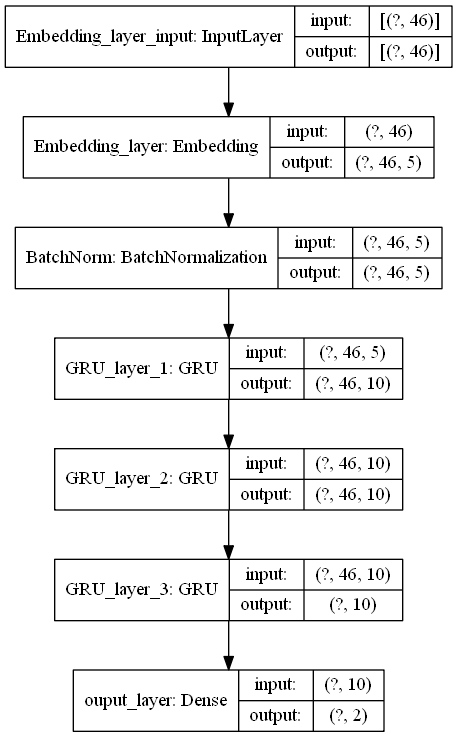

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model1, show_shapes=True)

In [60]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.fit(pads, pd.concat([df_nn['is_humor'], 1-df_nn['is_humor']], axis=1, keys=['is_humor', 'not_humor']), batch_size=10, epochs=5, verbose=2, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/5
7200/7200 - 269s - loss: 0.6674 - accuracy: 0.6147 - val_loss: 0.6691 - val_accuracy: 0.6075
Epoch 2/5
7200/7200 - 249s - loss: 0.6439 - accuracy: 0.6410 - val_loss: 0.5641 - val_accuracy: 0.7125
Epoch 3/5
7200/7200 - 245s - loss: 0.4386 - accuracy: 0.8035 - val_loss: 0.4356 - val_accuracy: 0.7862
Epoch 4/5
7200/7200 - 254s - loss: 0.2609 - accuracy: 0.8975 - val_loss: 0.4822 - val_accuracy: 0.7962
Epoch 5/5
7200/7200 - 245s - loss: 0.1825 - accuracy: 0.9346 - val_loss: 0.5524 - val_accuracy: 0.7725


In [24]:
model2 = Sequential(name="RNN2")
model2.add(Embedding(input_dim=len(set_of_words) + 1, 
                    output_dim=word_dimension,
                    embeddings_initializer=Constant(word2vec_matrix),
                    input_length=max([len(elem) for elem in df['text']]),
                    trainable=True,
                    name="Embedding_layer")
         )
model1.add(BatchNormalization(name="BatchNorm"))
model2.add(LSTM(units=10, return_sequences=True, name="LSTM_layer_1"))
model2.add(LSTM(units=10, return_sequences=True, name="LSTM_layer_2"))
model2.add(LSTM(units=10, name="LSTM_layer_3"))
model2.add(Dense(2, activation="softmax", name="ouput_layer"))

In [34]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.fit(pads, pd.concat([df_nn['is_humor'], 1-df_nn['is_humor']], axis=1, keys=['is_humor', 'not_humor']), batch_size=10, epochs=5, verbose=2, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/5
7200/7200 - 41s - loss: 0.0368 - accuracy: 0.9892 - val_loss: 0.8248 - val_accuracy: 0.8225
Epoch 2/5
7200/7200 - 18s - loss: 0.0243 - accuracy: 0.9947 - val_loss: 0.8880 - val_accuracy: 0.8275
Epoch 3/5
7200/7200 - 16s - loss: 0.0222 - accuracy: 0.9958 - val_loss: 0.7953 - val_accuracy: 0.8225
Epoch 4/5
7200/7200 - 18s - loss: 0.0211 - accuracy: 0.9962 - val_loss: 0.8461 - val_accuracy: 0.8238
Epoch 5/5
7200/7200 - 18s - loss: 0.0186 - accuracy: 0.9961 - val_loss: 1.0223 - val_accuracy: 0.8275


In [52]:
model3 = Sequential(name="RNN3")
model3.add(Embedding(input_dim=len(set_of_words) + 1, 
                    output_dim=word_dimension,
                    embeddings_initializer=Constant(word2vec_matrix),
                    input_length=max([len(elem) for elem in df['text']]),
                    trainable=True,
                    name="Embedding_layer")
         )
model3.add(BatchNormalization())
model3.add(LSTM(units=10, activation="relu", recurrent_activation="relu", return_sequences=True, name="LSTM_layer_1"))
model3.add(BatchNormalization())
model3.add(LSTM(units=10, activation="relu", recurrent_activation="relu", return_sequences=True, name="LSTM_layer_2"))
model3.add(Dropout(rate=0.2))
model3.add(BatchNormalization())
model3.add(LSTM(units=10, activation="relu", recurrent_activation="relu", name="LSTM_layer_3"))
model3.add(Dense(2, activation="softmax", name="ouput_layer"))

In [53]:
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.fit(pads, pd.concat([df_nn['is_humor'], 1-df_nn['is_humor']], axis=1, keys=['is_humor', 'not_humor']), batch_size=10, epochs=5, verbose=2, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/5
7200/7200 - 124s - loss: 0.6739 - accuracy: 0.6175 - val_loss: 0.6701 - val_accuracy: 0.6075
Epoch 2/5
7200/7200 - 123s - loss: 0.6654 - accuracy: 0.6175 - val_loss: 0.6703 - val_accuracy: 0.6075
Epoch 3/5
7200/7200 - 132s - loss: 0.6654 - accuracy: 0.6175 - val_loss: 0.6700 - val_accuracy: 0.6075
Epoch 4/5
7200/7200 - 129s - loss: 0.6654 - accuracy: 0.6175 - val_loss: 0.6701 - val_accuracy: 0.6075
Epoch 5/5
7200/7200 - 128s - loss: 0.6654 - accuracy: 0.6175 - val_loss: 0.6701 - val_accuracy: 0.6075


In [49]:
model4 = Sequential(name="RNN4")
model4.add(Embedding(input_dim=len(set_of_words) + 1, 
                    output_dim=word_dimension,
                    embeddings_initializer=Constant(word2vec_matrix),
                    input_length=max([len(elem) for elem in df['text']]),
                    trainable=True,
                    name="Embedding_layer")
         )
model4.add(LSTM(units=100, activation='relu', return_sequences=False, name="GRU_layer_1"))
model4.add(Dropout(rate=0.2))
model4.add(BatchNormalization())
model4.add(Dense(2, activation="softmax", name="ouput_layer"))

In [50]:
model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model4.fit(pads, pd.concat([df_nn['is_humor'], 1-df_nn['is_humor']], axis=1, keys=['is_humor', 'not_humor']), batch_size=10, epochs=5, verbose=2, validation_split=0.1)

Train on 7200 samples, validate on 800 samples
Epoch 1/5
7200/7200 - 61s - loss: 0.6635 - accuracy: 0.6257 - val_loss: 0.6638 - val_accuracy: 0.6250
Epoch 2/5
7200/7200 - 44s - loss: 0.5519 - accuracy: 0.7215 - val_loss: 0.4436 - val_accuracy: 0.8050
Epoch 3/5
7200/7200 - 44s - loss: 0.3215 - accuracy: 0.8758 - val_loss: 0.4491 - val_accuracy: 0.8087
Epoch 4/5
7200/7200 - 47s - loss: 0.2142 - accuracy: 0.9257 - val_loss: 0.5059 - val_accuracy: 0.8213
Epoch 5/5
7200/7200 - 54s - loss: 0.1495 - accuracy: 0.9572 - val_loss: 0.5590 - val_accuracy: 0.8138


In [10]:
encoding = input() #doc-term or tf-idf
train_func = lambda enc : (doc_term_train[doc_term_train.columns[:-4]], doc_term_train[doc_term_train.columns[-4]]) \
                          if enc == 'doc_term' \
                          else \
                          (tf_idf_train[tf_idf_train.columns[:-4]], tf_idf_train[tf_idf_train.columns[-4]]) \
                          if enc == 'tf-idf' \
                          else \
                          (one_hot_train[one_hot_train.columns[:-4]], one_hot_train[one_hot_train.columns[-4]])
        
test_func = lambda enc : (doc_term_test[doc_term_test.columns[:-4]], doc_term_test[doc_term_test.columns[-4]]) \
                         if enc == 'doc_term' \
                         else \
                         (tf_idf_test[tf_idf_test.columns[:-4]], tf_idf_test[tf_idf_test.columns[-4]]) \
                         if enc == 'tf-idf' \
                         else \
                         (one_hot_test[one_hot_test.columns[:-4]], one_hot_test[one_hot_test.columns[-4]])

X_train, Y_train = train_func(encoding)
X_test, Y_test = test_func(encoding)

doc-term


In [11]:
#Laplace smoothing,  alpha is a smoothing hyperparameter
multinomialNB_clf = MultinomialNB(alpha=1)
multinomialNB_clf.fit(X_train, Y_train)
multinomialNB_predictions = multinomialNB_clf.predict(X_test)
print("Accuracy with MultinomialNB, " + encoding + " encoding:" , accuracy_score(Y_test, multinomialNB_predictions))

Accuracy with MultinomialNB, doc-term encoding: 0.833


In [12]:
complementNB_clf = ComplementNB(alpha=1)
complementNB_clf.fit(X_train, Y_train)
complementNB_predictions = complementNB_clf.predict(X_test)
print("Accuracy with CNB, " + encoding + " encoding:", accuracy_score(Y_test, complementNB_predictions))

Accuracy with CNB, doc-term encoding: 0.832


In [13]:
bernoulliNB_clf = BernoulliNB(alpha=1, binarize=None)
bernoulliNB_clf.fit(X_train, Y_train)
bernoulliNB_predictions = bernoulliNB_clf.predict(X_test)
print("Accuracy with BNB, " + encoding + " encoding:", accuracy_score(Y_test, bernoulliNB_predictions))

Accuracy with BNB, doc-term encoding: 0.802


In [56]:
%%time
logreg_clf = LogisticRegression(penalty='l2', dual=True, C=1.5, n_jobs=-1)
logreg_clf.fit(X_train, Y_train)
logreg_predictions = logreg_clf.predict(X_test)
print("Accuracy with Logistic Regression, " + encoding + " encoding:", accuracy_score(Y_test, logreg_predictions))

C:\Users\Tudor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Tudor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy with Logistic Regression, doc-term encoding: 0.8165
Wall time: 1.14 s


In [14]:
%%time
svm_linear_clf = SVC(C=1, kernel='linear', cache_size=1000, probability=True, verbose=True)
svm_linear_clf.fit(X_train, Y_train)
svm_linear_predictions = svm_linear_clf.predict(X_test)
print("Accuracy with SVM linear kernel, " + encoding + " encoding:", accuracy_score(Y_test, svm_linear_predictions))

[LibSVM]Accuracy with SVM linear kernel, doc-term encoding: 0.7955
Wall time: 25min 32s


In [15]:
%%time
svm_poly_clf = SVC(C=1, kernel='poly', degree=2, coef0=1, cache_size=1000, probability=True, verbose=True)
svm_poly_clf.fit(X_train, Y_train)
svm_poly_predictions = svm_poly_clf.predict(X_test)
print("Accuracy with SVM polynomial kernel, " + encoding + " encoding:", accuracy_score(Y_test, svm_poly_predictions))

C:\Users\Tudor\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]Accuracy with SVM polynomial kernel, doc-term encoding: 0.612
Wall time: 37min 58s


In [17]:
%%time
svm_poly_d3_clf = SVC(C=1, kernel='poly', degree=3, coef0=1, cache_size=1000, probability=True, verbose=True)
svm_poly_d3_clf.fit(X_train, Y_train)
svm_poly_d3_predictions = svm_poly_d3_clf.predict(X_test)
print("Accuracy with SVM polynomial kernel, " + encoding + " encoding:", accuracy_score(Y_test, svm_poly_d3_predictions))

C:\Users\Tudor\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]Accuracy with SVM polynomial kernel, doc-term encoding: 0.612
Wall time: 38min 12s


In [18]:
%%time
grid_search = RandomizedSearchCV(estimator = SVC(), 
                                 param_distributions = {'C' : scipy.stats.expon(scale=100), 
                                                        'kernel': ['rbf'],
                                                        'gamma': scipy.stats.expon(scale=.1),
                                                        'class_weight': ['balanced', None]},
                                 n_iter = 1,
                                 scoring = 'accuracy', 
                                 n_jobs = -1,
                                 cv = None
                                )
grid_search.fit(X_train, Y_train)
r = pd.DataFrame(grid_search.cv_results_)
r[r['rank_test_score'] == 1]

C:\Users\Tudor\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 12min 51s
Parser   : 131 ms


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,223.197081,2.288619,110.525484,0.512095,2.26374,None,0.0364975,rbf,"{'C': 2.2637391282206, 'class_weight': None, '...",0.8205,0.8045,0.8145,0.813167,0.0066,1


------------------------------- ROC Curve --------------------------------------------------------------


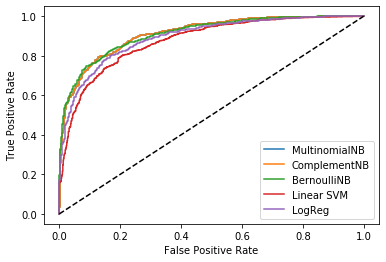

AUC for MultinomialNB: 0.912559
AUC for ComplementNB: 0.912559
AUC for BernoulliNB: 0.911669
AUC for Linear SVM: 0.875772
AUC for LogReg: 0.894172


In [58]:
print("------------------------------- ROC Curve --------------------------------------------------------------")
fpr, tpr, thresholds = roc_curve(Y_test, multinomialNB_clf.predict_proba(X_test)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(Y_test, complementNB_clf.predict_proba(X_test)[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(Y_test, bernoulliNB_clf.predict_proba(X_test)[:, 1])
fpr4, tpr4, thresholds4 = roc_curve(Y_test, svm_linear_clf.predict_proba(X_test)[:, 1])
fpr5, tpr5, thresholds5 = roc_curve(Y_test, logreg_clf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label = "ROC curve")
plt.plot(fpr2, tpr2, label = "ROC curve")
plt.plot(fpr3, tpr3, label = "ROC curve")
plt.plot(fpr4, tpr4, label = "ROC curve")
plt.plot(fpr5, tpr5, label = "ROC curve")

plt.legend(["MultinomialNB", "ComplementNB", "BernoulliNB", "Linear SVM", "LogReg"])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("AUC for MultinomialNB: %f" % (roc_auc_score(Y_test, multinomialNB_clf.predict_proba(X_test)[:, 1])))
print("AUC for ComplementNB: %f" % (roc_auc_score(Y_test, complementNB_clf.predict_proba(X_test)[:, 1])))
print("AUC for BernoulliNB: %f" % (roc_auc_score(Y_test, bernoulliNB_clf.predict_proba(X_test)[:, 1])))
print("AUC for Linear SVM: %f" % (roc_auc_score(Y_test, svm_linear_clf.predict_proba(X_test)[:, 1])))
print("AUC for LogReg: %f" % (roc_auc_score(Y_test, logreg_clf.predict_proba(X_test)[:, 1])))

In [59]:
print('---------------------------- MultinomialNB --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != multinomialNB_predictions).sum()))
print("The accuracy score is : %f" % (accuracy_score(Y_test, multinomialNB_predictions)))
cm = confusion_matrix(Y_test, multinomialNB_predictions)
print(cm)
print(classification_report(Y_test, multinomialNB_predictions))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(Y_test, multinomialNB_predictions))

---------------------------- MultinomialNB --------------------------------------------
Number of mislabeled points out of a total 2000 points : 334
The accuracy score is : 0.833000
[[ 556  220]
 [ 114 1110]]
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       776
           1       0.83      0.91      0.87      1224

    accuracy                           0.83      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.83      0.83      0.83      2000

Balanced accuacy score:  0.811678795229432


In [60]:
print('---------------------------- ComplementNB --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != complementNB_predictions).sum()))
print("The accuracy score is : %f" % (accuracy_score(Y_test, complementNB_predictions)))
cm = confusion_matrix(Y_test, complementNB_predictions)
print(cm)
print(classification_report(Y_test, complementNB_predictions))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(Y_test, complementNB_predictions))

---------------------------- ComplementNB --------------------------------------------
Number of mislabeled points out of a total 2000 points : 336
The accuracy score is : 0.832000
[[ 595  181]
 [ 155 1069]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       776
           1       0.86      0.87      0.86      1224

    accuracy                           0.83      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.83      0.83      0.83      2000

Balanced accuacy score:  0.8200592951957415


In [61]:
print('---------------------------- BernoulliNB --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != bernoulliNB_predictions).sum()))
print("The accuracy score is : %f" % (accuracy_score(Y_test, bernoulliNB_predictions)))
cm = confusion_matrix(Y_test, bernoulliNB_predictions)
print(cm)
print(classification_report(Y_test, bernoulliNB_predictions))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(Y_test, bernoulliNB_predictions))

---------------------------- BernoulliNB --------------------------------------------
Number of mislabeled points out of a total 2000 points : 396
The accuracy score is : 0.802000
[[ 442  334]
 [  62 1162]]
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       776
           1       0.78      0.95      0.85      1224

    accuracy                           0.80      2000
   macro avg       0.83      0.76      0.77      2000
weighted avg       0.82      0.80      0.79      2000

Balanced accuacy score:  0.7594670170473687


In [62]:
print('---------------------------- Logistic Regression --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != logreg_predictions).sum()))
print("The accuracy score is : %f" % (accuracy_score(Y_test, logreg_predictions)))
cm = confusion_matrix(Y_test, logreg_predictions)
print(cm)
print(classification_report(Y_test, logreg_predictions))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(Y_test, logreg_predictions))

---------------------------- Logistic Regression --------------------------------------------
Number of mislabeled points out of a total 2000 points : 367
The accuracy score is : 0.816500
[[ 580  196]
 [ 171 1053]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       776
           1       0.84      0.86      0.85      1224

    accuracy                           0.82      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.82      0.82      0.82      2000

Balanced accuacy score:  0.803858399029715


In [63]:
print('---------------------------- Linear SVM --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != svm_linear_predictions).sum()))
print("The accuracy score is : %f" % (accuracy_score(Y_test, svm_linear_predictions)))
cm = confusion_matrix(Y_test, svm_linear_predictions)
print(cm)
print(classification_report(Y_test, svm_linear_predictions))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(Y_test, svm_linear_predictions))

---------------------------- Linear SVM --------------------------------------------
Number of mislabeled points out of a total 2000 points : 409
The accuracy score is : 0.795500
[[ 580  196]
 [ 213 1011]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       776
           1       0.84      0.83      0.83      1224

    accuracy                           0.80      2000
   macro avg       0.78      0.79      0.79      2000
weighted avg       0.80      0.80      0.80      2000

Balanced accuacy score:  0.7867015362846169


TypeError: learning_curve() got an unexpected keyword argument 'return_times'

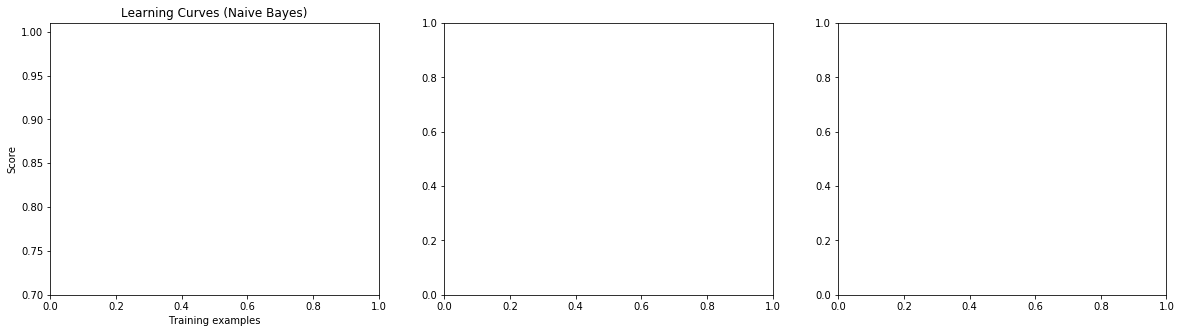

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
plot_learning_curve(multinomialNB_clf, title, X_train, Y_train, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()


In [27]:
conda install scikit-learn=0.23.2

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: scikit-learn=0.23.2



Note: you may need to restart the kernel to use updated packages.
